# Tutorial 3: Hierarchical regression

## Load packages

In [ ]:
# Install rpy2 to use R code in Colab notebook
!pip3 install rpy2 
%load_ext rpy2.ipython

In [ ]:
%%R
if (!require("pacman")) install.packages("pacman")
pacman::p_load("tidyverse",
               "brms", 
               "dagitty",
               "dplyr",
               "ggplot2",
               "GGally",
               "ggpubr",
               "ggrepel",
               "ggsci",
               "ggthemes",
               "grid",
               "gridExtra",
               "bayesplot",
               "loo",
               "lubridate",
               "MASS",
               "modelr",
               "posterior",
               "psych",
               "rcompanion",
               "hues",
               "RColorBrewer",
               "scales",
               "sp",
               "spdep",
               "tidybayes")

# Let us analyze the data and re-create the graphics from the following article:
## "[Visualization in Bayesian workflow](https://arxiv.org/pdf/1709.01449.pdf)"

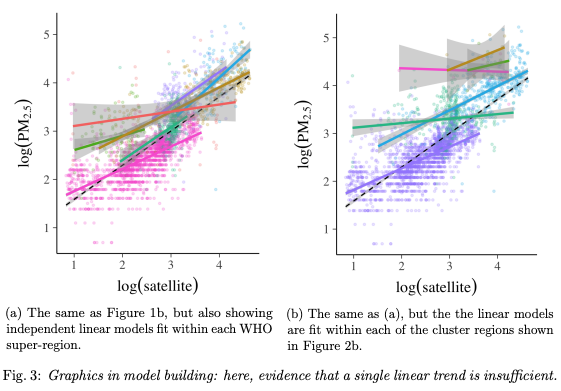

## Read data

In [6]:
%%R
# load 'GM' SpatialPointsDataFrame
load("/content/bayes-vis.RData")

GM@data <- GM@data %>% 
  mutate(
    log_pm25 = log(pm25), 
    log_sat = log(sat_2014)
  )

In [7]:
%%R
# regions via clustering to compare to WHO super-regions
average <- 
  GM@data %>% 
  group_by(iso3) %>% 
  summarise(pm25 = mean(pm25))

d <- dist(average)

hh <- hclust(d)

clust <- cutree(hh,k = 6)

GM@data$cluster_region <-
  sapply(GM@data$iso3, function(x) clust[which(average$iso3 == x)])

In [8]:
%%R
# SOURCE: https://dplyr.tidyverse.org/reference/glimpse.html
glimpse(GM@data)

Rows: 2,980
Columns: 10
$ City_locality     <fct> "", "\xb4\xe8_\xb4\xe8__lhavo", "\xb4\xe8_\xb4\xe8__…
$ iso3              <fct> AUS, PRT, ESP, DEU, DNK, DEU, NOR, BEL, NGA, NGA, ES…
$ country           <fct> "Australia", "Portugal", "Spain", "Germany", "Denmar…
$ super_region      <int> 1, 1, 1, 1, 1, 1, 1, 1, 7, 7, 1, 4, 1, 1, 2, 1, 2, 1…
$ super_region_name <fct> HighIncome, HighIncome, HighIncome, HighIncome, High…
$ pm25              <dbl> 33.463801, 15.000000, 10.000000, 13.000000, 11.00000…
$ sat_2014          <dbl> 33.314292, 9.867000, 9.175500, 15.537997, 9.798502, …
$ log_pm25          <dbl> 3.510464, 2.708050, 2.302585, 2.564949, 2.397895, 2.…
$ log_sat           <dbl> 3.505986, 2.289196, 2.216537, 2.743288, 2.282230, 2.…
$ cluster_region    <int> 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 3, 2, 4, 2…


In [9]:
%%R
head(GM@data, 10)

# A tibble: 10 × 10
   City_lo…¹ iso3  country super…² super…³  pm25 sat_2…⁴ log_p…⁵ log_sat clust…⁶
   <fct>     <fct> <fct>     <int> <fct>   <dbl>   <dbl>   <dbl>   <dbl>   <int>
 1 ""        AUS   Austra…       1 HighIn…  33.5   33.3     3.51    3.51       2
 2 "\xb4\xe… PRT   Portug…       1 HighIn…  15      9.87    2.71    2.29       2
 3 "\xb4\xe… ESP   Spain         1 HighIn…  10      9.18    2.30    2.22       2
 4 "AACHEN"  DEU   Germany       1 HighIn…  13     15.5     2.56    2.74       2
 5 "AALBORG" DNK   Denmark       1 HighIn…  11      9.80    2.40    2.28       2
 6 "AALEN"   DEU   Germany       1 HighIn…  12     19.3     2.48    2.96       2
 7 "AALESUN… NOR   Norway        1 HighIn…   7.5    4.73    2.01    1.55       2
 8 "AARSCHO… BEL   Belgium       1 HighIn…  15     15.8     2.71    2.76       2
 9 "Aba"     NGA   Nigeria       7 Sub-Sa…  49     45.8     3.89    3.82       4
10 "Abakali… NGA   Nigeria       7 Sub-Sa…  28     52.2     3.33    3.96       4
# … with

## Check for missing values

In [10]:
%%R
sum(is.na(GM@data))

[1] 0


## Exploratory Data Analysis (EDA)

### $PM_{2.5}$: direct measurements of particulate matter measuring less than 2.5 microns in diameter ($PM_{2.5}$)
### $satellite$: high-resolution satellite data that converted aerosol optical depth measures into estimates of $PM_{2.5}$

#### Average log(PM2.5) and log(satellite) by WHO super-region

In [11]:
%%R
# SOURCE: https://r4ds.had.co.nz/transform.html#grouped-summaries-with-summarise
GM@data %>%
  group_by(super_region_name) %>% # super_region_name
  summarize(Mean_log_pm25 = mean(log_pm25, na.rm = TRUE),
            Mean_log_sat  = mean(log_sat, na.rm = TRUE))

# A tibble: 7 × 3
  super_region_name      Mean_log_pm25 Mean_log_sat
  <fct>                          <dbl>        <dbl>
1 E-Eur/C-Eur/C-Asia              3.09         3.01
2 HighIncome                      2.39         2.36
3 LatAm/Carib                     2.87         1.88
4 N-Afr/MidEast                   3.68         3.22
5 S-Asia                          3.98         3.85
6 SE-Asia/E-Asia/Oceania          3.76         3.70
7 Sub-Saharan Afr                 3.38         2.85


## View relationship between log(PM2.5) and log(satellite)

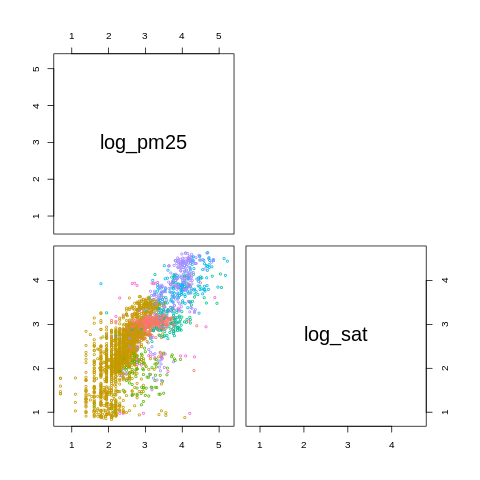

In [20]:
#@title Pairs plot of log(PM2.5) and log(satellite), colored by WHO super-region
%%R
# SOURCES: 
# http://www.sthda.com/english/wiki/scatter-plot-matrices-r-base-graphs
# https://scales.r-lib.org/reference/hue_pal.html

# super_region_colors = c("#00C094", "#FB61D7", "#53B400", "#A58AFF", "#00B6EB", "#C49A00", "#F8766D")

pairs(GM@data[,c("log_pm25", "log_sat")], 
      pch = 1, 
      cex = 0.5, 
      col = scales::hue_pal()(7)[GM@data$super_region_name], 
      upper.panel=NULL)

In [33]:
%%R
bind_cols(unique(GM@data$super_region_name), unique(scales::hue_pal()(7)[GM@data$super_region_name]))

New names:
• `` -> `...1`
• `` -> `...2`
# A tibble: 7 × 2
  ...1                   ...2   
  <fct>                  <chr>  
1 HighIncome             #C49A00
2 Sub-Saharan Afr        #FB61D7
3 E-Eur/C-Eur/C-Asia     #F8766D
4 N-Afr/MidEast          #00C094
5 S-Asia                 #00B6EB
6 LatAm/Carib            #53B400
7 SE-Asia/E-Asia/Oceania #A58AFF


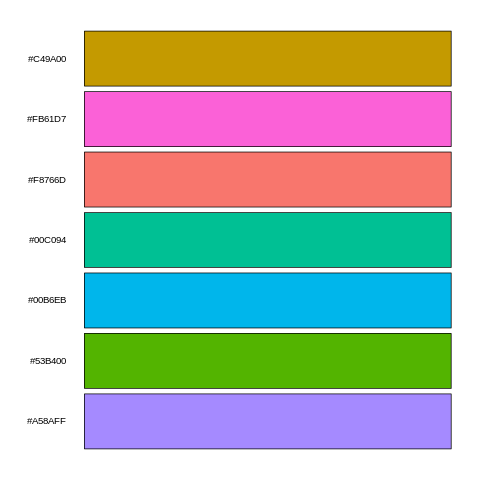

In [32]:
%%R
hues::swatch(unique(scales::hue_pal()(7)[GM@data$super_region_name]))

#### Average log(PM2.5) and log(satellite) by 6-component hierarchical clustering of ground monitor measurements of PM2.5

In [ ]:
%%R
# SOURCE: https://r4ds.had.co.nz/transform.html#grouped-summaries-with-summarise
GM@data %>%
  group_by(as.factor(cluster_region)) %>% # cluster_region
  summarize(Mean_log_pm25 = mean(log_pm25, na.rm = TRUE),
            Mean_log_sat  = mean(log_sat, na.rm = TRUE))

# A tibble: 6 × 3
  `as.factor(cluster_region)` Mean_log_pm25 Mean_log_sat
  <fct>                               <dbl>        <dbl>
1 1                                    4.30         3.64
2 2                                    2.44         2.39
3 3                                    3.89         3.80
4 4                                    3.31         2.99
5 5                                    4.42         3.82
6 6                                    4.61         3.69


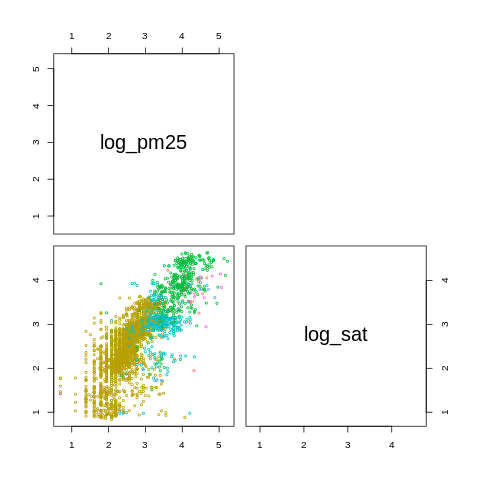

In [42]:
#@title Pairs plot of log(PM2.5) and log(satellite), colored by cluster
%%R
# SOURCES: 
# http://www.sthda.com/english/wiki/scatter-plot-matrices-r-base-graphs
# https://scales.r-lib.org/reference/hue_pal.html

# cluster_region_colors = c("#FB61D7", "#A58AFF", "#00B6EB", "#00C094", "#53B400", "#C49A00", "#F8766D")

pairs(GM@data[,c("log_pm25", "log_sat")], 
      pch = 1, 
      cex = 0.5, 
      col = scales::hue_pal()(6)[as.factor(GM@data$cluster_region)], 
      upper.panel=NULL)

In [43]:
%%R
bind_cols(levels(as.factor(GM@data$cluster_region)), unique(scales::hue_pal()(6)[as.factor(GM@data$cluster_region)]))

New names:
• `` -> `...1`
• `` -> `...2`
# A tibble: 6 × 2
  ...1  ...2   
  <chr> <chr>  
1 1     #B79F00
2 2     #00BFC4
3 3     #00BA38
4 4     #F564E3
5 5     #619CFF
6 6     #F8766D


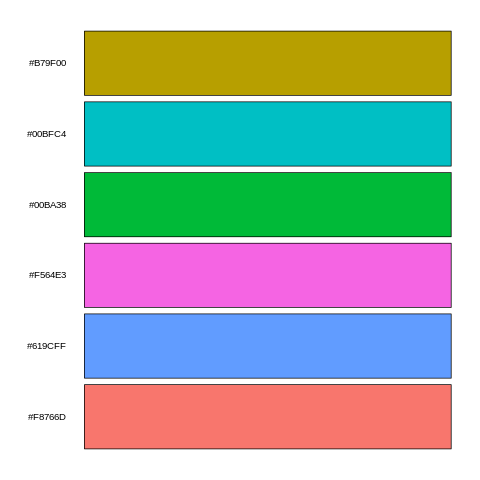

In [44]:
%%R
hues::swatch(unique(scales::hue_pal()(6)[as.factor(GM@data$cluster_region)]))

## View relationship between *direct* measurements of particulate matter measuring less than 2.5 microns in diameter ($PM_{2.5}$) and *high-resolution satellite data* that converted measurements of aerosol optical depth into estimates of $PM_{2.5}$.

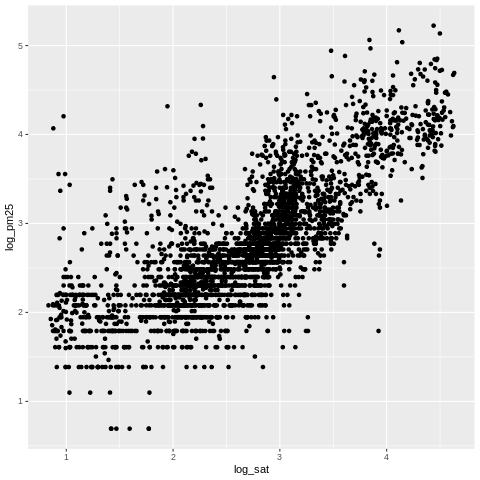

In [ ]:
%%R
g1 <-  ggplot(GM@data, aes(y = log_pm25, x = log_sat))

g1 + geom_point()

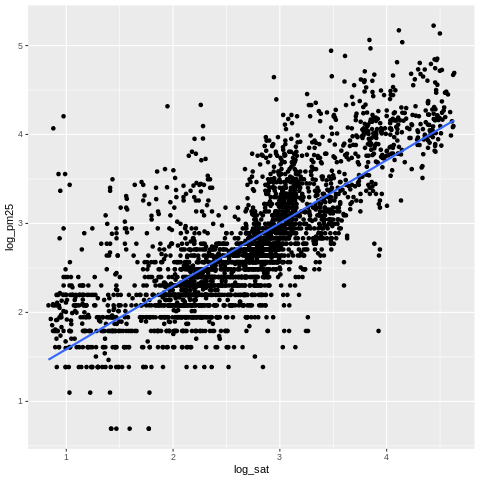

In [ ]:
%%R
g1 <-  ggplot(GM@data, aes(y = log_pm25, x = log_sat))

g1 + 
  geom_point() +
  geom_smooth(formula = y ~ x, method = "lm", se = FALSE)

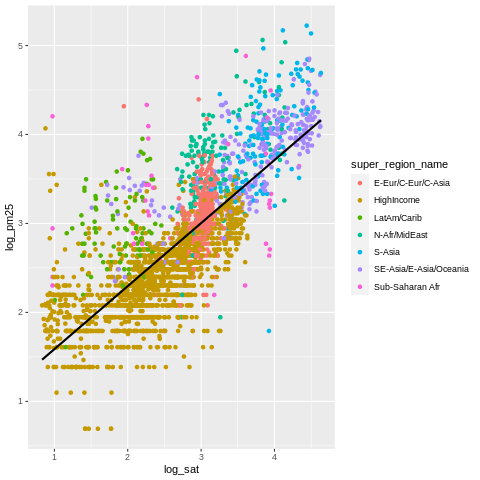

In [ ]:
%%R
g1 <-  ggplot(GM@data, aes(y = log_pm25, x = log_sat))

g1 + 
  geom_point(aes(color = super_region_name)) +
  geom_smooth(formula = y ~ x, method = "lm", se = FALSE, color = "black")

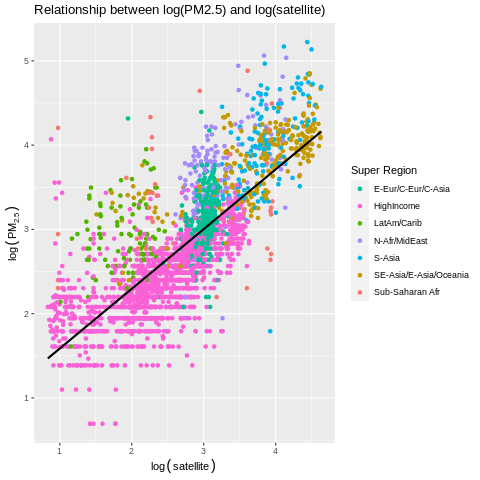

In [ ]:
%%R
g1 <-  ggplot(GM@data, aes(y = log_pm25, x = log_sat))

g1 + 
  geom_point(aes(color = super_region_name)) +
  scale_color_manual(
    name = "Super Region",
    values = 
      c("E-Eur/C-Eur/C-Asia" = "#00C094",
        "HighIncome" = "#FB61D7",
        "LatAm/Carib" = "#53B400",
        "N-Afr/MidEast" = "#A58AFF",
        "S-Asia" = "#00B6EB",
        "SE-Asia/E-Asia/Oceania" = "#C49A00",
        "Sub-Saharan Afr" = "#F8766D")
  ) +
  geom_smooth(formula = y ~ x, method = "lm", se = FALSE, color = "black") +
  scale_x_continuous(name = expression(log(satellite))) +
  scale_y_continuous(name = expression(log(PM[2.5]))) +
  ggtitle("Relationship between log(PM2.5) and log(satellite)")

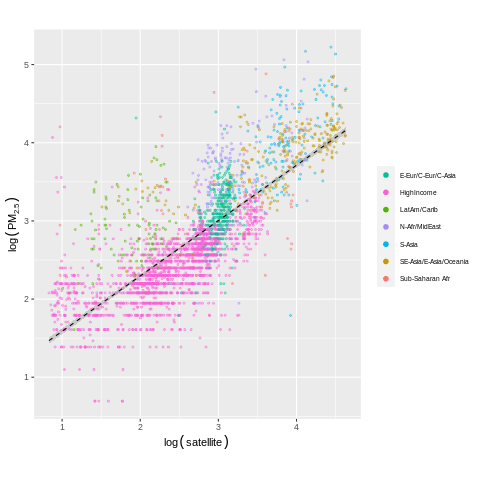

In [62]:
%%R
# Exploratory plots -------------------------------------------------------

xylabs <- labs(
  x = expression(log(satellite)), 
  y = expression(log(PM[2.5]))
)

# Plot log(pm2.5) vs log(sat), coloured by super-region
plot1 <- ggplot(GM@data, aes(y = log_pm25, x = log_sat)) +
  geom_point(
    aes(color = super_region_name), 
    alpha = 0.4,
    size = rel(0.8)
  ) + 
  scale_color_manual(
    values = 
      c("E-Eur/C-Eur/C-Asia" = "#00C094",
        "HighIncome" = "#FB61D7",
        "LatAm/Carib" = "#53B400",
        "N-Afr/MidEast" = "#A58AFF",
        "S-Asia" = "#00B6EB",
        "SE-Asia/E-Asia/Oceania" = "#C49A00",
        "Sub-Saharan Afr" = "#F8766D")
  ) +
  geom_smooth(
    method = lm, 
    color = "black", 
    size = 0.5, 
    linetype = 2
  ) + 
  coord_equal() +
  xylabs + 
  guides(color = guide_legend(
    title = NULL, 
    override.aes = list(alpha = 1, size = 2)
  )) + 
  theme(legend.text = element_text(size = rel(0.6)))

plot(plot1)

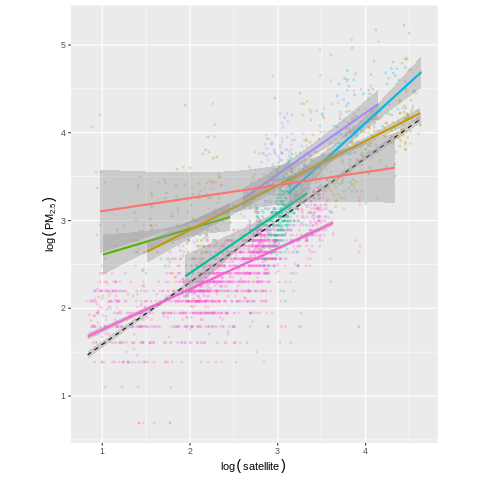

In [ ]:
%%R
# Plot: log(pm2.5) vs log(sat) with super-region trends
plot2 <-
  ggplot(GM@data, aes(
    y = log_pm25,
    x = log_sat
  )) +
  geom_point(aes(colour = super_region_name), alpha = 0.2, size = rel(0.75)) + 
  geom_smooth(
    method = lm, 
    color = "black", 
    size = 0.5, 
    linetype = 2
  ) + 
  scale_color_manual(
    values = 
      c("E-Eur/C-Eur/C-Asia" = "#00C094",
        "HighIncome" = "#FB61D7",
        "LatAm/Carib" = "#53B400",
        "N-Afr/MidEast" = "#A58AFF",
        "S-Asia" = "#00B6EB",
        "SE-Asia/E-Asia/Oceania" = "#C49A00",
        "Sub-Saharan Afr" = "#F8766D")
  ) +
  geom_smooth(aes(colour = super_region_name), method = lm) + 
  coord_equal() +
  xylabs + 
  legend_none() 

plot(plot2)

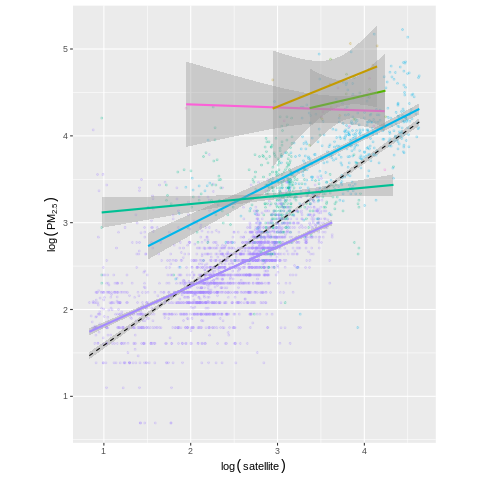

In [ ]:
%%R
# Plot: log(pm2.5) vs log(sat) with trends by regions from clustering
plot3 <-
  ggplot(GM@data, aes(
    y = log_pm25,
    x = log_sat
  )) + 
  geom_point(aes(colour = as.factor(cluster_region)), alpha = 0.2, size = rel(0.75)) + 
  scale_color_manual(
    values = 
      c("4" = "#00C094",
        "1" = "#FB61D7",
        "5" = "#53B400",
        "2" = "#A58AFF",
        "3" = "#00B6EB",
        "6" = "#C49A00",
        "7" = "#F8766D")
  ) +
  geom_smooth(
    method = lm, 
    color = "black", 
    size = 0.5, 
    linetype = 2
  ) + 
  geom_smooth(aes(colour = as.factor(cluster_region)), method = lm) + 
  coord_equal() +
  xylabs +
  legend_none()

plot(plot3)

## Prior predictive simulation

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/geocentric-models.html#the-linear-model-strategy.
set.seed(2971)

n_lines <- 100

lines <-
  tibble(n = 1:n_lines,
         a = rnorm(n_lines, mean = 3, sd = 2),
         b = rnorm(n_lines, mean = 0, sd = 2)) %>% 
  expand(nesting(n, a, b), log_sat = range(GM@data$log_sat)) %>% 
  mutate(log_pm25 = a + b * (log_sat - mean(log_sat)))

head(lines)

# A tibble: 6 × 5
      n     a      b log_sat log_pm25
  <int> <dbl>  <dbl>   <dbl>    <dbl>
1     1  4.26 -1.41    0.833     6.94
2     1  4.26 -1.41    4.63      1.58
3     2  5.12  0.168   0.833     4.80
4     2  5.12  0.168   4.63      5.43
5     3  5.36  0.785   0.833     3.87
6     3  5.36  0.785   4.63      6.85


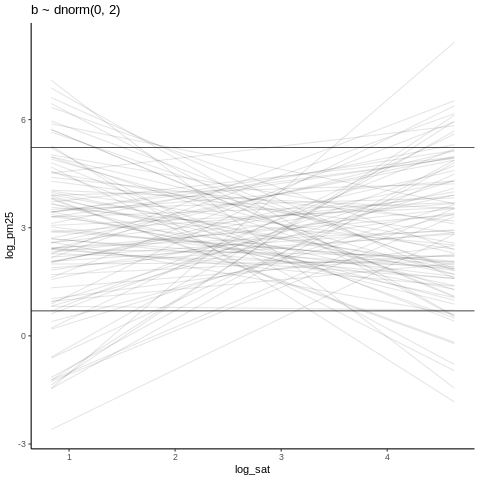

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/geocentric-models.html#the-linear-model-strategy.
lines %>% 
  ggplot(aes(x = log_sat, y = log_pm25, group = n)) +
  geom_hline(yintercept = c(min(GM@data$log_pm25), max(GM@data$log_pm25)), linetype = 1:1, size = 1/3) +
  geom_line(alpha = 1/10) +
  ggtitle("b ~ dnorm(0, 2)") +
  theme_classic()

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/geocentric-models.html#the-linear-model-strategy.
set.seed(2971)

n_lines <- 100

lines <-
  tibble(n = 1:n_lines,
         a = rnorm(n_lines, mean = 3, sd = 1),
         b = rnorm(n_lines, mean = 0, sd = 0.5)) %>% 
  expand(nesting(n, a, b), log_sat = range(GM@data$log_sat)) %>% 
  mutate(log_pm25 = a + b * (log_sat - mean(log_sat)))

head(lines)

# A tibble: 6 × 5
      n     a       b log_sat log_pm25
  <int> <dbl>   <dbl>   <dbl>    <dbl>
1     1  3.63 -0.353    0.833     4.30
2     1  3.63 -0.353    4.63      2.96
3     2  4.06  0.0420   0.833     3.98
4     2  4.06  0.0420   4.63      4.14
5     3  4.18  0.196    0.833     3.81
6     3  4.18  0.196    4.63      4.55


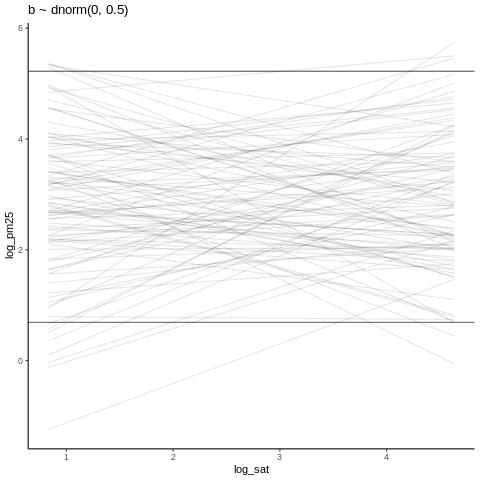

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/geocentric-models.html#the-linear-model-strategy.
lines %>% 
  ggplot(aes(x = log_sat, y = log_pm25, group = n)) +
  geom_hline(yintercept = c(min(GM@data$log_pm25), max(GM@data$log_pm25)), linetype = 1:1, size = 1/3) +
  geom_line(alpha = 1/10) +
  ggtitle("b ~ dnorm(0, 0.5)") +
  theme_classic()

## Fit a model

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/geocentric-models.html#finding-the-posterior-distribution.
b1 <- 
  brm(data = GM@data, 
      family = gaussian,
      log_pm25 ~ 1 + log_sat,
      chains = 4, cores = 4, seed = 4)

In [ ]:
%%R
prior_summary(b1)

                  prior     class    coef group resp dpar nlpar lb ub
                 (flat)         b                                    
                 (flat)         b log_sat                            
 student_t(3, 2.7, 2.5) Intercept                                    
   student_t(3, 0, 2.5)     sigma                                0   
       source
      default
 (vectorized)
      default
      default


In [ ]:
%%R
print(b1)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: log_pm25 ~ 1 + log_sat 
   Data: GM@data (Number of observations: 2980) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.88      0.03     0.82     0.94 1.00     4078     2813
log_sat       0.71      0.01     0.69     0.73 1.00     4060     3166

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.45      0.01     0.44     0.46 1.00     4219     2849

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).


In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/geocentric-models.html#interpreting-the-posterior-distribution.
posterior_summary(b1)[1:3, ] %>% 
  round(digits = 2)

            Estimate Est.Error Q2.5 Q97.5
b_Intercept     0.88      0.03 0.82  0.94
b_log_sat       0.71      0.01 0.69  0.73
sigma           0.45      0.01 0.44  0.46


In [ ]:
%%R
# SOURCE: https://mjskay.github.io/tidybayes/articles/tidy-brms.html
b1 %>%
  gather_draws(b_Intercept, b_log_sat, sigma) %>%
  median_qi()

# A tibble: 3 × 7
  .variable   .value .lower .upper .width .point .interval
  <chr>        <dbl>  <dbl>  <dbl>  <dbl> <chr>  <chr>    
1 b_Intercept  0.879  0.820  0.937   0.95 median qi       
2 b_log_sat    0.708  0.687  0.730   0.95 median qi       
3 sigma        0.449  0.437  0.461   0.95 median qi       


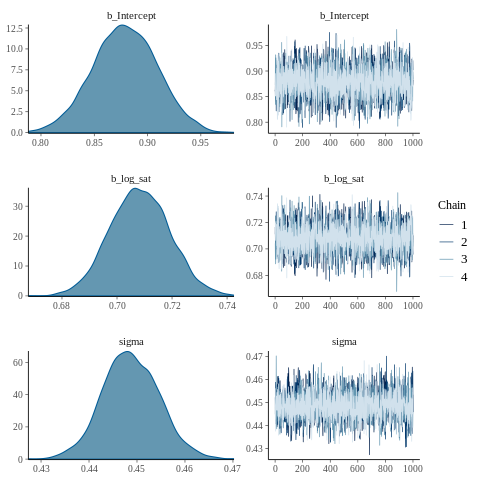

In [ ]:
%%R
plot(b1)

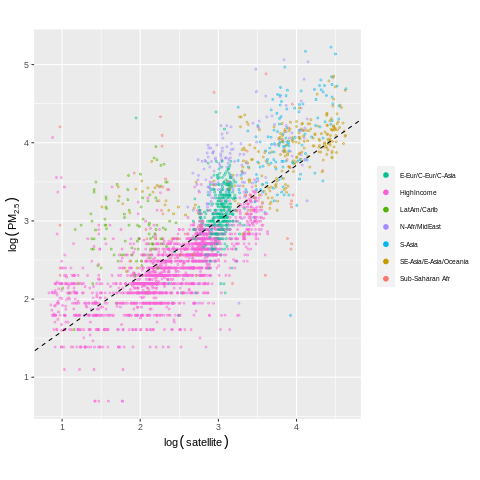

In [ ]:
%%R
# Plot log(pm2.5) vs log(sat), coloured by super-region
p1 <- ggplot(GM@data, aes(y = log_pm25, x = log_sat)) +
  geom_point(
    aes(color = super_region_name), 
    alpha = 0.4,
    size = rel(0.8)
  ) + 
  scale_color_manual(
    values = 
      c("E-Eur/C-Eur/C-Asia" = "#00C094",
        "HighIncome" = "#FB61D7",
        "LatAm/Carib" = "#53B400",
        "N-Afr/MidEast" = "#A58AFF",
        "S-Asia" = "#00B6EB",
        "SE-Asia/E-Asia/Oceania" = "#C49A00",
        "Sub-Saharan Afr" = "#F8766D")
  ) +
  geom_abline(intercept = fixef(b1)[1], 
              slope     = fixef(b1)[2], 
              color = "black", 
              size = 0.5, 
              linetype = 2
  ) + 
  coord_equal() +
  xylabs + 
  guides(color = guide_legend(
    title = NULL, 
    override.aes = list(alpha = 1, size = 2)
  )) + 
  theme(legend.text = element_text(size = rel(0.6)))

p1

In [ ]:
%%R
# Pareto smoothed importance-sampling leave-one-out cross-validation (PSIS-LOO)
b1 <- add_criterion(b1, criterion = "loo")

In [ ]:
%%R
# Widely applicable information criterion (WAIC)
b1 <- add_criterion(b1, criterion = "waic")

## Fit a varying-intercepts model

In [45]:
%%R
# SOURCE: https://bookdown.org/content/4857/geocentric-models.html#finding-the-posterior-distribution.
b2 <- 
  brm(data = GM@data, 
      family = gaussian,
      log_pm25 ~ 1 + log_sat + (1|super_region_name),
      chains = 4, cores = 4, seed = 4)

In [ ]:
%%R
prior_summary(b2)

                  prior     class      coef             group resp dpar nlpar
                 (flat)         b                                            
                 (flat)         b   log_sat                                  
 student_t(3, 2.7, 2.5) Intercept                                            
   student_t(3, 0, 2.5)        sd                                            
   student_t(3, 0, 2.5)        sd           super_region_name                
   student_t(3, 0, 2.5)        sd Intercept super_region_name                
   student_t(3, 0, 2.5)     sigma                                            
 lb ub       source
            default
       (vectorized)
            default
  0         default
  0    (vectorized)
  0    (vectorized)
  0         default


In [ ]:
%%R
print(b2)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: log_pm25 ~ 1 + log_sat + (1 | super_region_name) 
   Data: GM@data (Number of observations: 2980) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Group-Level Effects: 
~super_region_name (Number of levels: 7) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.41      0.15     0.22     0.81 1.00      585     1153

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     1.89      0.17     1.55     2.24 1.00      777      919
log_sat       0.47      0.01     0.45     0.49 1.00     2726     2362

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.35      0.00     0.34     0.35 1.00     2862     1912

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size m

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/geocentric-models.html#interpreting-the-posterior-distribution.
posterior_summary(b2) %>% 
  round(digits = 2)

                                                      Estimate Est.Error
b_Intercept                                               1.89      0.17
b_log_sat                                                 0.47      0.01
sd_super_region_name__Intercept                           0.41      0.15
sigma                                                     0.35      0.00
r_super_region_name[E-Eur/C-Eur/C-Asia,Intercept]        -0.22      0.16
r_super_region_name[HighIncome,Intercept]                -0.62      0.16
r_super_region_name[LatAm/Carib,Intercept]                0.09      0.17
r_super_region_name[N-Afr/MidEast,Intercept]              0.27      0.17
r_super_region_name[S-Asia,Intercept]                     0.26      0.17
r_super_region_name[SE-Asia/E-Asia/Oceania,Intercept]     0.12      0.17
r_super_region_name[Sub-Saharan.Afr,Intercept]            0.14      0.17
lprior                                                   -4.42      0.02
lp__                                               

In [ ]:
%%R
# SOURCE: https://mjskay.github.io/tidybayes/articles/tidy-brms.html
b2 %>%
  gather_draws(b_Intercept, b_log_sat, sigma) %>%
  median_qi()

# A tibble: 3 × 7
  .variable   .value .lower .upper .width .point .interval
  <chr>        <dbl>  <dbl>  <dbl>  <dbl> <chr>  <chr>    
1 b_Intercept  1.89   1.55   2.24    0.95 median qi       
2 b_log_sat    0.471  0.450  0.493   0.95 median qi       
3 sigma        0.346  0.337  0.355   0.95 median qi       


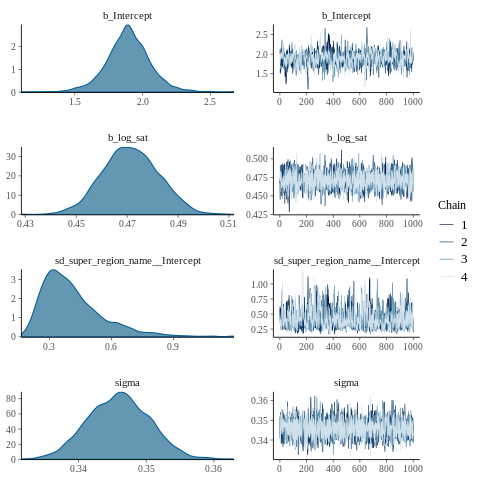

In [ ]:
%%R
plot(b2)

In [60]:
%%R
as_draws_df(b2) %>% 
  mutate(`E-Eur/C-Eur/C-Asia`     = b_Intercept + `r_super_region_name[E-Eur/C-Eur/C-Asia,Intercept]`,
         `HighIncome`             = b_Intercept + `r_super_region_name[HighIncome,Intercept]`,
         `LatAm/Carib`            = b_Intercept + `r_super_region_name[LatAm/Carib,Intercept]`,
         `N-Afr/MidEast`          = b_Intercept + `r_super_region_name[N-Afr/MidEast,Intercept]`,
         `S-Asia`                 = b_Intercept + `r_super_region_name[S-Asia,Intercept]`,
         `SE-Asia/E-Asia/Oceania` = b_Intercept + `r_super_region_name[SE-Asia/E-Asia/Oceania,Intercept]`,
         `Sub-Saharan Afr`        = b_Intercept + `r_super_region_name[Sub-Saharan.Afr,Intercept]`) %>%
  dplyr::select(`E-Eur/C-Eur/C-Asia`:`Sub-Saharan Afr`, b_log_sat, sigma) %>%
  posterior_summary() %>% 
  round(digits = 2)

                       Estimate Est.Error Q2.5 Q97.5
E-Eur/C-Eur/C-Asia         1.67      0.04 1.60  1.75
HighIncome                 1.27      0.03 1.22  1.33
LatAm/Carib                1.98      0.04 1.90  2.06
N-Afr/MidEast              2.16      0.04 2.07  2.25
S-Asia                     2.16      0.05 2.06  2.26
SE-Asia/E-Asia/Oceania     2.01      0.05 1.92  2.10
Sub-Saharan Afr            2.03      0.06 1.91  2.16
b_log_sat                  0.47      0.01 0.45  0.49
sigma                      0.35      0.00 0.34  0.35


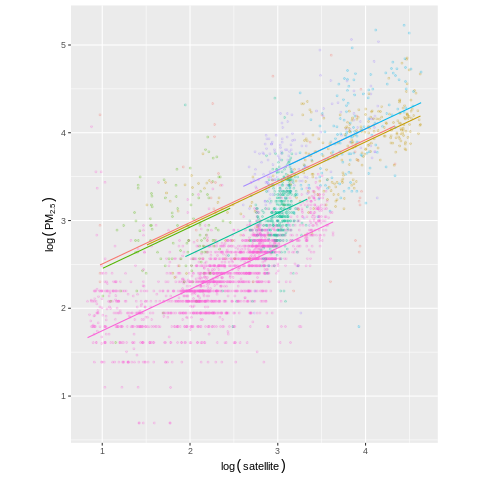

In [67]:
%%R
# Plot: log(pm2.5) vs log(sat) with super-region trends
p2 <-
  ggplot(GM@data, aes(
    y = log_pm25,
    x = log_sat
  )) +
  geom_point(aes(colour = super_region_name), alpha = 0.2, size = rel(0.75)) + 
  scale_color_manual(
    values = 
      c("E-Eur/C-Eur/C-Asia" = "#00C094",
        "HighIncome" = "#FB61D7",
        "LatAm/Carib" = "#53B400",
        "N-Afr/MidEast" = "#A58AFF",
        "S-Asia" = "#00B6EB",
        "SE-Asia/E-Asia/Oceania" = "#C49A00",
        "Sub-Saharan Afr" = "#F8766D")
  ) +
  geom_line(aes(y=fitted(b2)[,"Estimate"], 
            group = super_region_name, 
            colour = super_region_name),
            size = 0.5, 
            linetype = 1) +
  coord_equal() +
  xylabs + 
  legend_none() 

p2

In [ ]:
%%R
# Pareto smoothed importance-sampling leave-one-out cross-validation (PSIS-LOO)
b2 <- add_criterion(b2, criterion = "loo")

In [ ]:
%%R
# Widely applicable information criterion (WAIC)
b2 <- add_criterion(b2, criterion = "waic")

## Fit a varying-intercepts, varying-slopes model

In [68]:
%%R
# SOURCE: https://bookdown.org/content/4857/geocentric-models.html#finding-the-posterior-distribution.
b3 <- 
  brm(data = GM@data, 
      family = gaussian,
      log_pm25 ~ 1 + log_sat + (1 + log_sat|super_region_name),
      chains = 4, cores = 4, seed = 4)

In [70]:
%%R
prior_summary(b3)

                  prior     class      coef             group resp dpar nlpar
                 (flat)         b                                            
                 (flat)         b   log_sat                                  
 student_t(3, 2.7, 2.5) Intercept                                            
   lkj_corr_cholesky(1)         L                                            
   lkj_corr_cholesky(1)         L           super_region_name                
   student_t(3, 0, 2.5)        sd                                            
   student_t(3, 0, 2.5)        sd           super_region_name                
   student_t(3, 0, 2.5)        sd Intercept super_region_name                
   student_t(3, 0, 2.5)        sd   log_sat super_region_name                
   student_t(3, 0, 2.5)     sigma                                            
 lb ub       source
            default
       (vectorized)
            default
            default
       (vectorized)
  0         default
  

In [71]:
%%R
print(b3)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: log_pm25 ~ 1 + log_sat + (1 + log_sat | super_region_name) 
   Data: GM@data (Number of observations: 2980) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Group-Level Effects: 
~super_region_name (Number of levels: 7) 
                       Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)              0.92      0.33     0.47     1.73 1.00     1181
sd(log_sat)                0.29      0.11     0.15     0.54 1.01     1005
cor(Intercept,log_sat)    -0.82      0.17    -0.98    -0.32 1.00     1529
                       Tail_ESS
sd(Intercept)              1607
sd(log_sat)                1737
cor(Intercept,log_sat)     1989

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     1.67      0.37     0.95     2.44 1.00     1160     1614
log_sat       0.52      0.12     0.27     0.75 1.00     1

In [72]:
%%R
# SOURCE: https://bookdown.org/content/4857/geocentric-models.html#interpreting-the-posterior-distribution.
posterior_summary(b3) %>% 
  round(digits = 2)

                                                      Estimate Est.Error
b_Intercept                                               1.67      0.37
b_log_sat                                                 0.52      0.12
sd_super_region_name__Intercept                           0.92      0.33
sd_super_region_name__log_sat                             0.29      0.11
cor_super_region_name__Intercept__log_sat                -0.82      0.17
sigma                                                     0.34      0.00
r_super_region_name[E-Eur/C-Eur/C-Asia,Intercept]        -0.51      0.47
r_super_region_name[HighIncome,Intercept]                -0.38      0.37
r_super_region_name[LatAm/Carib,Intercept]                0.59      0.40
r_super_region_name[N-Afr/MidEast,Intercept]             -0.21      0.41
r_super_region_name[S-Asia,Intercept]                    -1.03      0.45
r_super_region_name[SE-Asia/E-Asia/Oceania,Intercept]     0.20      0.39
r_super_region_name[Sub-Saharan.Afr,Intercept]     

In [ ]:
%%R
# SOURCE: https://mjskay.github.io/tidybayes/articles/tidy-brms.html
b3 %>%
  gather_draws(b_Intercept, b_log_sat, sigma) %>%
  median_qi()

# A tibble: 3 × 7
  .variable   .value .lower .upper .width .point .interval
  <chr>        <dbl>  <dbl>  <dbl>  <dbl> <chr>  <chr>    
1 b_Intercept  1.67   0.953  2.44    0.95 median qi       
2 b_log_sat    0.518  0.272  0.751   0.95 median qi       
3 sigma        0.342  0.333  0.351   0.95 median qi       


Hit <Return> to see next plot: 


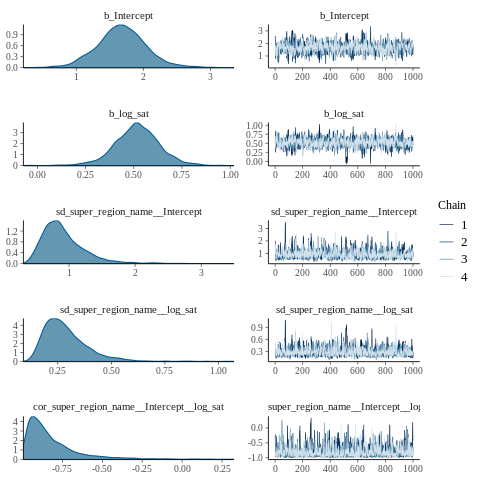

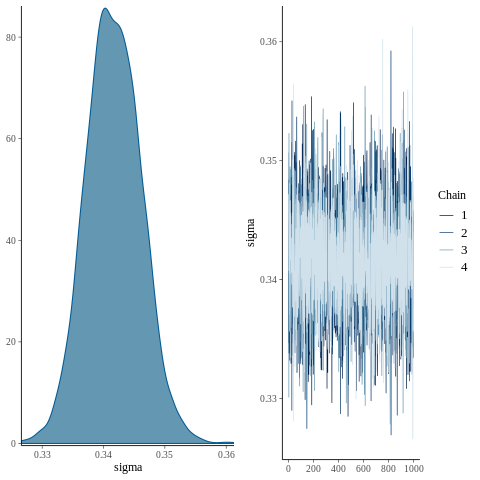

In [ ]:
%%R
plot(b3)

In [83]:
%%R
as_draws_df(b3) %>% 
  mutate(`E-Eur/C-Eur/C-Asia_Intercept`     = b_Intercept + `r_super_region_name[E-Eur/C-Eur/C-Asia,Intercept]`,
         `HighIncome_Intercept`             = b_Intercept + `r_super_region_name[HighIncome,Intercept]`,
         `LatAm/Carib_Intercept`            = b_Intercept + `r_super_region_name[LatAm/Carib,Intercept]`,
         `N-Afr/MidEast_Intercept`          = b_Intercept + `r_super_region_name[N-Afr/MidEast,Intercept]`,
         `S-Asia_Intercept`                 = b_Intercept + `r_super_region_name[S-Asia,Intercept]`,
         `SE-Asia/E-Asia/Oceania_Intercept` = b_Intercept + `r_super_region_name[SE-Asia/E-Asia/Oceania,Intercept]`,
         `Sub-Saharan Afr_Intercept`        = b_Intercept + `r_super_region_name[Sub-Saharan.Afr,Intercept]`,

         `E-Eur/C-Eur/C-Asia_Slope`     = b_log_sat + `r_super_region_name[E-Eur/C-Eur/C-Asia,log_sat]`,
         `HighIncome_Slope`             = b_log_sat + `r_super_region_name[HighIncome,log_sat]`,
         `LatAm/Carib_Slope`            = b_log_sat + `r_super_region_name[LatAm/Carib,log_sat]`,
         `N-Afr/MidEast_Slope`          = b_log_sat + `r_super_region_name[N-Afr/MidEast,log_sat]`,
         `S-Asia_Slope`                 = b_log_sat + `r_super_region_name[S-Asia,log_sat]`,
         `SE-Asia/E-Asia/Oceania_Slope` = b_log_sat + `r_super_region_name[SE-Asia/E-Asia/Oceania,log_sat]`,
         `Sub-Saharan Afr_Slope`        = b_log_sat + `r_super_region_name[Sub-Saharan.Afr,log_sat]`) %>%
  dplyr::select(`E-Eur/C-Eur/C-Asia_Intercept`:`Sub-Saharan Afr_Slope`, sigma) %>%
  posterior_summary() %>% 
  round(digits = 2)

                                 Estimate Est.Error Q2.5 Q97.5
E-Eur/C-Eur/C-Asia_Intercept         1.17      0.34 0.51  1.83
HighIncome_Intercept                 1.29      0.03 1.23  1.35
LatAm/Carib_Intercept                2.26      0.17 1.93  2.60
N-Afr/MidEast_Intercept              1.46      0.20 1.06  1.87
S-Asia_Intercept                     0.64      0.31 0.04  1.24
SE-Asia/E-Asia/Oceania_Intercept     1.87      0.11 1.66  2.09
Sub-Saharan Afr_Intercept            2.90      0.17 2.57  3.23
E-Eur/C-Eur/C-Asia_Slope             0.64      0.11 0.42  0.86
HighIncome_Slope                     0.46      0.01 0.44  0.49
LatAm/Carib_Slope                    0.33      0.09 0.15  0.50
N-Afr/MidEast_Slope                  0.69      0.06 0.56  0.81
S-Asia_Slope                         0.87      0.08 0.71  1.02
SE-Asia/E-Asia/Oceania_Slope         0.51      0.03 0.45  0.57
Sub-Saharan Afr_Slope                0.17      0.06 0.06  0.27
sigma                                0.34      0.00 0.3

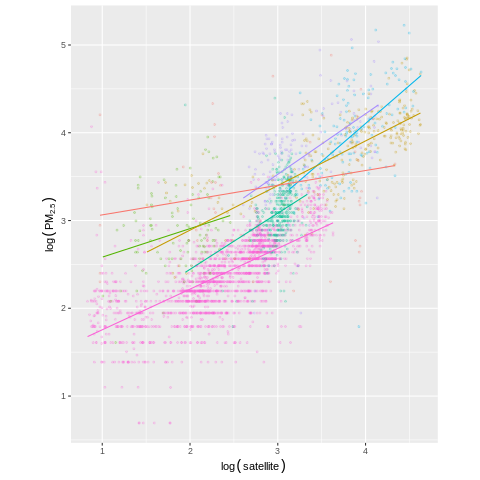

In [74]:
%%R
# Plot: log(pm2.5) vs log(sat) with super-region trends
p3 <-
  ggplot(GM@data, aes(
    y = log_pm25,
    x = log_sat
  )) +
  geom_point(aes(colour = super_region_name), alpha = 0.2, size = rel(0.75)) + 
  scale_color_manual(
    values = 
      c("E-Eur/C-Eur/C-Asia" = "#00C094",
        "HighIncome" = "#FB61D7",
        "LatAm/Carib" = "#53B400",
        "N-Afr/MidEast" = "#A58AFF",
        "S-Asia" = "#00B6EB",
        "SE-Asia/E-Asia/Oceania" = "#C49A00",
        "Sub-Saharan Afr" = "#F8766D")
  ) +
  geom_line(aes(y=fitted(b3)[,"Estimate"], 
            group = super_region_name, 
            colour = super_region_name),
            size = 0.5,
            linetype = 1) +
  coord_equal() +
  xylabs + 
  legend_none() 

p3

In [ ]:
%%R
# Pareto smoothed importance-sampling leave-one-out cross-validation (PSIS-LOO)
b3 <- add_criterion(b3, criterion = "loo")

In [ ]:
%%R
# Widely applicable information criterion (WAIC)
b3 <- add_criterion(b3, criterion = "waic")

## Model comparison

In [ ]:
%%R
# SOURCE: https://bookdown.org/content/4857/ulysses-compass.html#model-mis-selection.
w <- loo_compare(b1, b2, b3, criterion = "waic") %>% 
  
print(w, simplify = F)

   elpd_diff se_diff elpd_waic se_elpd_waic p_waic  se_p_waic waic    se_waic
b3     0.0       0.0 -1043.1      66.8         29.5     4.8    2086.3   133.5
b2   -30.4      14.2 -1073.6      66.2         16.4     1.7    2147.1   132.4
b1  -798.7      43.5 -1841.8      55.4          4.5     0.5    3683.7   110.8


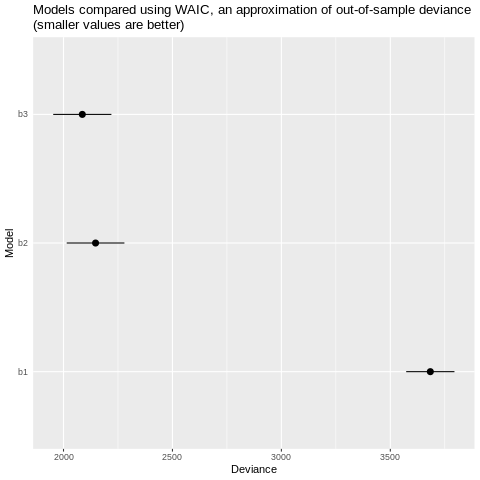

In [ ]:
%%R
# WAIC comparison plot
w[, 7:8] %>% 
  data.frame() %>% 
  rownames_to_column("model_name") %>% 
  mutate(model_name = fct_reorder(model_name, waic, .desc = T)) %>% 
  
  ggplot(aes(x = waic, y = model_name, 
             xmin = waic - se_waic, 
             xmax = waic + se_waic)) +
  geom_pointrange() +
  labs(title = "Models compared using WAIC, an approximation of out-of-sample deviance\n(smaller values are better)",
       x = "Deviance", y = "Model") +
  theme(axis.ticks.y = element_blank())

## Plots to communicate and explain

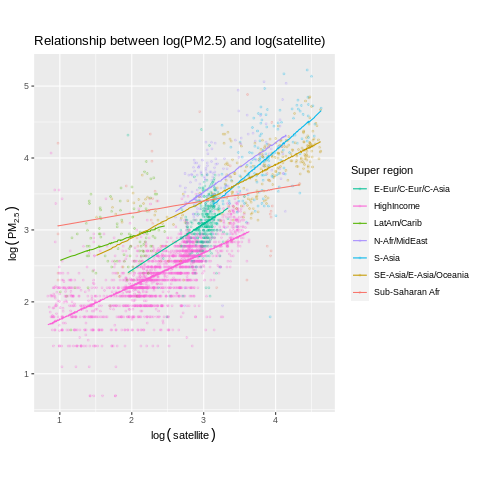

In [ ]:
#@title Initial plot with points and fitted lines colored by WHO super-region
%%R
# SOURCES: 
# https://www.datanovia.com/en/blog/ggplot-colors-best-tricks-you-will-love/
# https://cran.r-project.org/web/packages/ggsci/vignettes/ggsci.html
g3 <-
  ggplot(GM@data, aes(
    y = log_pm25,
    x = log_sat
  )) +
  geom_point(aes(colour = super_region_name), alpha = 0.2, size = rel(0.75)) + 
  scale_color_manual(
    name = "Super region",
    values = 
      c("E-Eur/C-Eur/C-Asia" = "#00C094",
        "HighIncome" = "#FB61D7",
        "LatAm/Carib" = "#53B400",
        "N-Afr/MidEast" = "#A58AFF",
        "S-Asia" = "#00B6EB",
        "SE-Asia/E-Asia/Oceania" = "#C49A00",
        "Sub-Saharan Afr" = "#F8766D")
  ) +
  geom_line(aes(y=predict(b3)[,"Estimate"], 
            group = super_region_name, 
            colour = super_region_name),
            size = 0.5,
            linetype = 1) +
  coord_equal() +
  scale_x_continuous(name = expression(log(satellite))) +
  scale_y_continuous(name = expression(log(PM[2.5]))) +
  ggtitle("Relationship between log(PM2.5) and log(satellite)")

g3

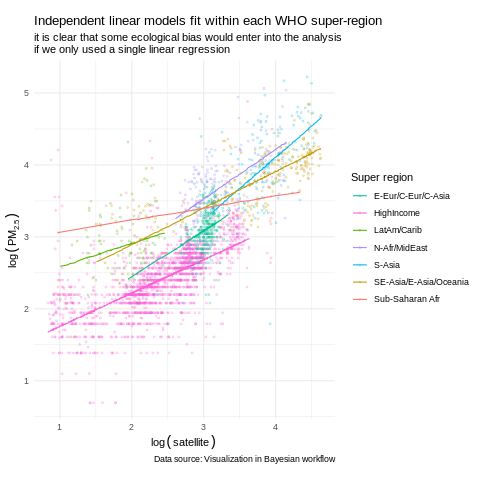

In [ ]:
#@title Change theme and add title and labels
%%R
# SOURCES: 
# https://ggplot2.tidyverse.org/articles/faq-axes.html
# https://ggplot2.tidyverse.org/articles/faq-customising.html
# https://github.com/EmilHvitfeldt/r-color-palettes
g4 <-
  ggplot(GM@data, aes(
    y = log_pm25,
    x = log_sat
  )) +
  geom_point(aes(colour = super_region_name), alpha = 0.2, size = rel(0.75)) + 
  scale_color_manual(
    name = "Super region",
    values = 
      c("E-Eur/C-Eur/C-Asia" = "#00C094",
        "HighIncome" = "#FB61D7",
        "LatAm/Carib" = "#53B400",
        "N-Afr/MidEast" = "#A58AFF",
        "S-Asia" = "#00B6EB",
        "SE-Asia/E-Asia/Oceania" = "#C49A00",
        "Sub-Saharan Afr" = "#F8766D")
  ) +
  geom_line(aes(y=predict(b3)[,"Estimate"], 
            group = super_region_name, 
            colour = super_region_name),
            size = 0.5,
            linetype = 1) +
  coord_equal() +
  #xylabs + 
  scale_x_continuous(name = expression(log(satellite))) +
  scale_y_continuous(name = expression(log(PM[2.5]))) +
  labs(title = paste("Independent linear models fit within each WHO super-region"),
       subtitle = paste("It is clear that some ecological bias would enter into the analysis\nif we only used a single linear regression"),
       caption = paste("Data source: Visualization in Bayesian workflow")) +
  theme_minimal()
  #guides(color = guide_legend("Super Region")) +
  #theme(legend.position = "top")

g4

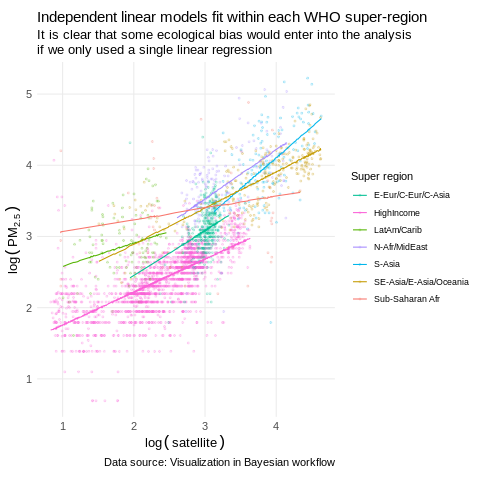

In [ ]:
#@title Increase font size and remove minor grid lines
%%R
# SOURCES: 
# https://ggplot2.tidyverse.org/articles/faq-axes.html
# https://ggplot2.tidyverse.org/articles/faq-customising.html
# https://github.com/EmilHvitfeldt/r-color-palettes
g5 <-
  ggplot(GM@data, aes(
    y = log_pm25,
    x = log_sat
  )) +
  geom_point(aes(colour = super_region_name), alpha = 0.2, size = rel(0.75)) + 
  scale_color_manual(
    name = "Super region",
    values = 
      c("E-Eur/C-Eur/C-Asia" = "#00C094",
        "HighIncome" = "#FB61D7",
        "LatAm/Carib" = "#53B400",
        "N-Afr/MidEast" = "#A58AFF",
        "S-Asia" = "#00B6EB",
        "SE-Asia/E-Asia/Oceania" = "#C49A00",
        "Sub-Saharan Afr" = "#F8766D")
  ) +
  geom_line(aes(y=predict(b3)[,"Estimate"], 
            group = super_region_name, 
            colour = super_region_name),
            size = 0.5,
            linetype = 1) +
  coord_equal() +
  scale_x_continuous(name = expression(log(satellite))) +
  scale_y_continuous(name = expression(log(PM[2.5]))) +
  labs(title = paste("Independent linear models fit within each WHO super-region"),
       subtitle = paste("It is clear that some ecological bias would enter into the analysis\nif we only used a single linear regression"),
       caption = paste("Data source: Visualization in Bayesian workflow")) +  
  theme_minimal(base_size = 11) +
  theme(plot.title = element_text(size = 15),
        plot.subtitle = element_text(size = 13),
        plot.caption = element_text(size = 11),
        axis.title.y = element_text(size = 13), # axis label
        axis.title.x = element_text(size = 13), # axis label
        axis.text.y = element_text(size = 11), # tick labels
        axis.text.x = element_text(size = 11), # tick labels
        panel.grid.minor.y = element_blank(),
        panel.grid.minor.x = element_blank(),
        legend.position = "right")

g5

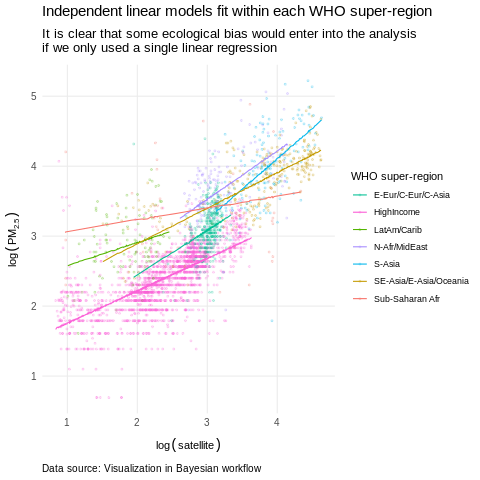

In [ ]:
#@title Add spacing around title, labels, and caption
%%R
# SOURCES: 
# https://ggplot2.tidyverse.org/articles/faq-axes.html
# https://ggplot2.tidyverse.org/articles/faq-customising.html
# https://github.com/EmilHvitfeldt/r-color-palettes
g6 <-
  ggplot(GM@data, aes(
    y = log_pm25,
    x = log_sat
  )) +
  geom_point(aes(colour = super_region_name), alpha = 0.2, size = rel(0.75)) + 
  scale_color_manual(
    name = "WHO super-region",
    values = 
      c("E-Eur/C-Eur/C-Asia" = "#00C094",
        "HighIncome" = "#FB61D7",
        "LatAm/Carib" = "#53B400",
        "N-Afr/MidEast" = "#A58AFF",
        "S-Asia" = "#00B6EB",
        "SE-Asia/E-Asia/Oceania" = "#C49A00",
        "Sub-Saharan Afr" = "#F8766D")
  ) +
  geom_line(aes(y=predict(b3)[,"Estimate"], 
            group = super_region_name, 
            colour = super_region_name),
            size = 0.5,
            linetype = 1) +
  coord_equal() +
  scale_x_continuous(name = expression(log(satellite))) +
  scale_y_continuous(name = expression(log(PM[2.5]))) +
  labs(title = paste("Independent linear models fit within each WHO super-region"),
       subtitle = paste("It is clear that some ecological bias would enter into the analysis\nif we only used a single linear regression"),
       caption = paste("Data source: Visualization in Bayesian workflow")) +  
  theme_minimal(base_size = 11) +
  theme(plot.title = element_text(size = 15, 
                                  margin = margin(t = 0, r = 0, b = 10, l = 0)),
        plot.subtitle = element_text(size = 13, 
                                     margin = margin(t = 0, r = 0, b = 10, l = 0)),
        axis.title.y = element_text(size = 11, 
                                    margin = margin(t = 0, r = 10, b = 0, l = 0)), # axis label
        axis.title.x = element_text(size = 11, 
                                    margin = margin(t = 10, r = 0, b = 0, l = 0)), # axis label
        axis.text.y = element_text(size = 10), # tick labels
        axis.text.x = element_text(size = 10), # tick labels
        panel.grid.minor.y = element_blank(),
        panel.grid.minor.x = element_blank(),
        legend.position = "right",
        plot.caption = element_text(hjust = 0, 
                                    size = 10, 
                                    margin = margin(t = 10, r = 0, b = 0, l = 0)))

g6